# Step1: frame splitting and raw output

In [4]:
import cv2
import os
import subprocess

# Step 1: Split MP4 video into frames
def extract_frames(video_path, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Save each frame as an image file
        frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.png")
        cv2.imwrite(frame_filename, frame)
        frame_count += 1

    cap.release()
    print(f"Extracted {frame_count} frames to {output_folder}")

# Step 2: Save frames as an uncompressed video using FFmpeg
def create_uncompressed_video(frame_folder, output_video_path, fps=30):
    # Check if the frame folder exists and contains frames
    if not os.path.exists(frame_folder):
        print(f"Error: Frame folder {frame_folder} does not exist.")
        return

    frame_files = [f for f in os.listdir(frame_folder) if f.startswith("frame_") and f.endswith(".png")]
    if not frame_files:
        print(f"Error: No frames found in {frame_folder}.")
        return

    # Use FFmpeg to create an uncompressed video from frames
    command = [
        'ffmpeg',
        '-y',  # Overwrite output file if it exists
        '-framerate', str(fps),  # Frame rate
        '-i', os.path.join(frame_folder, 'frame_%04d.png').replace("\\", "/"),  # Input frames
        '-c:v', 'rawvideo',  # Use raw video codec (uncompressed)
        '-pix_fmt', 'bgr24',  # Pixel format (matches OpenCV's BGR format)
        '-vf', 'format=bgr24',  # Explicitly set pixel format
        output_video_path.replace("\\", "/")  # Output video file
    ]

    # Print the FFmpeg command for debugging
    print("Running FFmpeg command:")
    print(" ".join(command))

    # Run the FFmpeg command
    try:
        subprocess.run(command, check=True)
        print(f"Uncompressed video saved to {output_video_path}")
    except subprocess.CalledProcessError as e:
        print(f"Error: FFmpeg command failed with exit code {e.returncode}.")
        print("Make sure FFmpeg is installed and added to your PATH.")
    except FileNotFoundError:
        print("Error: FFmpeg not found. Please install FFmpeg and add it to your PATH.")

# Main function
if __name__ == "__main__":
    # Input MP4 video file
    input_video = "./input.mp4"

    # Output folder for frames
    frames_folder = "./extracted_frames"

    # Output uncompressed video file
    output_video = "./output_uncompressed.avi"

    # Step 1: Extract frames from the MP4 video
    #extract_frames(input_video, frames_folder)

    # Step 2: Create an uncompressed video from the frames
    create_uncompressed_video(frames_folder, output_video)

Running FFmpeg command:
ffmpeg -y -framerate 30 -i ./extracted_frames/frame_%04d.png -c:v rawvideo -pix_fmt bgr24 -vf format=bgr24 ./output_uncompressed.avi
Error: FFmpeg command failed with exit code 4294967268.
Make sure FFmpeg is installed and added to your PATH.


GPU memory growth enabled.
Converting video to 180x180 (because size matters)...
Extracted 374 frames of size 180x180.
Using only the first 50 frames.
Final dataset: 50 frames of size 180x180.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 tf.math.multiply (TFOpLambda)  (None, 1)            0           ['input_1[0][0]']                
                                                                                                  
 tf.math.multiply_1 (TFOpLambda  (None, 1)           0           ['input_1[0][0]']                
 )                                                                                                


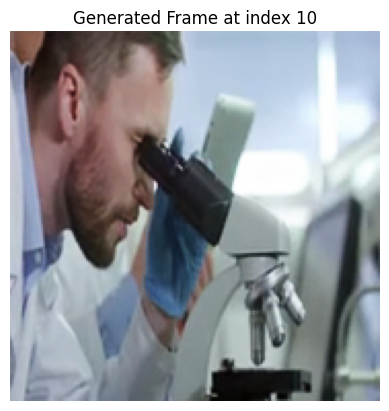

In [1]:
import os
import subprocess
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- GPU Memory Management ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)

# --- 1. Convert video to 180x180 using ffmpeg ---
video_output = "input_180x180.mp4"
if not os.path.exists(video_output):
    print("Converting video to 180x180 (because size matters)...")
    cmd = [
        "ffmpeg",
        "-i", "./input.mp4",
        "-vf", "scale=180:180",  # force video to 180x180 (aspect ratio may be squished)
        video_output
    ]
    subprocess.run(cmd, check=True)
else:
    print("180x180 video already exists, skipping conversion.")

# --- 2. Extract frames using OpenCV ---
cap = cv2.VideoCapture(video_output)
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame_rgb)
cap.release()

frames = np.array(frames)
print(f"Extracted {frames.shape[0]} frames of size {frames.shape[2]}x{frames.shape[1]}.")

# --- Limit to only 50 frames ---
if frames.shape[0] > 50:
    frames = frames[:50]
    print("Using only the first 50 frames.")

num_frames, H, W, C = frames.shape
print(f"Final dataset: {num_frames} frames of size {W}x{H}.")

# Normalize pixel values to [0, 1]
frames = frames.astype(np.float32) / 255.0

# --- 3. Prepare dataset: frame indices normalized to [0,1] ---
indices = np.linspace(0, 1, num_frames).reshape(-1, 1)

# --- 4. Positional encoding function (à la NeRF) ---
def positional_encoding(x, num_encoding_functions=6):
    encoding = [x]
    for i in range(num_encoding_functions):
        encoding.append(tf.sin((2.0 ** i) * np.pi * x))
        encoding.append(tf.cos((2.0 ** i) * np.pi * x))
    return tf.concat(encoding, axis=-1)

# --- 5. Build a smaller neural representation model ---
num_encoding_functions = 6
input_layer = tf.keras.Input(shape=(1,))
pe = positional_encoding(input_layer, num_encoding_functions)

# Two dense layers for a compact representation
x = tf.keras.layers.Dense(128, activation='relu')(pe)
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Map to a latent code instead of directly to a full image.
# Choose a latent resolution of 45x45 (so that two upsampling layers get to 180x180)
latent_channels = 128
latent_height = 45
latent_width = 45
flattened_dim = latent_height * latent_width * latent_channels

x = tf.keras.layers.Dense(flattened_dim, activation='relu')(x)
x = tf.keras.layers.Reshape((latent_height, latent_width, latent_channels))(x)

# Upsample: from 45x45 to 90x90 then to 180x180
x = tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)  # 45 -> 90
x = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(x)  # 90 -> 180

# Final layer to produce the 3-channel (RGB) output
output_layer = tf.keras.layers.Conv2D(C, kernel_size=3, strides=1, padding='same', activation='sigmoid')(x)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse')
model.summary()

# --- 6. Train the model ---
# Reduced batch size to ease GPU load; epochs set to 200 for quicker experimentation.
epochs = 200  # Tweak as needed
history = model.fit(indices, frames, epochs=epochs, batch_size=8, verbose=1)

# --- 7. Generate a frame by index ---
def generate_frame(frame_index, total_frames=num_frames):
    # Normalize index to [0,1]
    norm_index = np.array([[frame_index / (total_frames - 1)]], dtype=np.float32)
    pred_frame = model.predict(norm_index)
    pred_frame = np.clip(pred_frame[0], 0, 1)
    return (pred_frame * 255).astype(np.uint8)

# Example: Generate and display frame at index 10
frame_to_generate = 10
generated_frame = generate_frame(frame_to_generate)
plt.imshow(generated_frame)
plt.title(f"Generated Frame at index {frame_to_generate}")
plt.axis("off")
plt.show()


In [2]:
# --- 7. Save the model to disk ---
model_save_path = './video_model.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}.")

Model saved to ./video_model.h5.


# try 2

GPU memory growth enabled.
1080p video already exists, skipping conversion.
Extracted 374 frames of size 1920x1080.
Using only the first 10 frames.
Final dataset: 10 frames of size 1920x1080.
Padding frames to make dimensions divisible by 128x128.
New frame dimensions: 1920x1152.
Extracted 1350 blocks of shape (128, 128, 3) from 10 frames.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 tf.math.multiply_12 (TFOpLambd  (None, 3)           0           ['input_2[0][0]']                
 a)                                                                                               
                                               

Generating Frame 5: 100%|██████████| 135/135 [00:06<00:00, 20.94it/s]


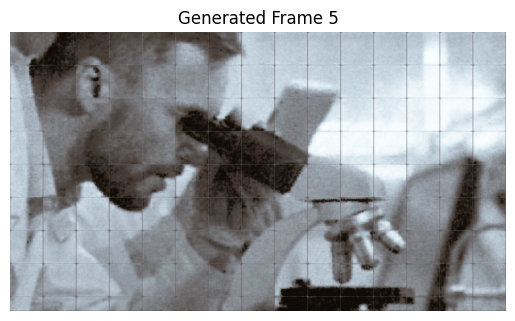

In [4]:
import os
import subprocess
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar during frame generation

# --- GPU Memory Management ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(f"Error setting GPU memory growth: {e}")

# --- 1. Convert Video to 1080p Using ffmpeg ---
video_input = "./input.mp4"
video_output = "input_1080p.mp4"

if not os.path.exists(video_input):
    raise FileNotFoundError(f"Input video '{video_input}' not found.")

if not os.path.exists(video_output):
    print("Converting video to 1080p...")
    cmd = [
        "ffmpeg",
        "-i", video_input,
        "-vf", "scale=1920:1080",
        "-y",  # Overwrite output if it exists
        video_output
    ]
    try:
        subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print("Video conversion completed.")
    except subprocess.CalledProcessError as e:
        raise RuntimeError(f"FFmpeg conversion failed: {e.stderr.decode()}")
else:
    print("1080p video already exists, skipping conversion.")

# --- 2. Extract Frames Using OpenCV ---
cap = cv2.VideoCapture(video_output)
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame_rgb)
cap.release()

if not frames:
    raise ValueError("No frames extracted from the video.")

frames = np.array(frames)
print(f"Extracted {frames.shape[0]} frames of size {frames.shape[2]}x{frames.shape[1]}.")

# Limit to 10 frames
if frames.shape[0] > 10:
    frames = frames[:10]
    print("Using only the first 10 frames.")

num_frames, H, W, C = frames.shape
original_H, original_W = H, W  # Store original dimensions
print(f"Final dataset: {num_frames} frames of size {W}x{H}.")

# Normalize pixel values to [0, 1]
frames = frames.astype(np.float32) / 255.0

# --- 3. Define Block Size and Padding ---
block_size = 128

# Pad frames to make dimensions divisible by block_size
pad_H = (block_size - H % block_size) % block_size
pad_W = (block_size - W % block_size) % block_size

if pad_H > 0 or pad_W > 0:
    print(f"Padding frames to make dimensions divisible by {block_size}x{block_size}.")
    frames = np.pad(frames, ((0, 0), (0, pad_H), (0, pad_W), (0, 0)), mode='constant')
    H, W = frames.shape[1], frames.shape[2]
    print(f"New frame dimensions: {W}x{H}.")

# --- 4. Extract Non-Overlapping 128x128 Blocks from All Frames ---
def extract_blocks(frame, block_size):
    """Extract non-overlapping blocks from a frame."""
    H, W, _ = frame.shape
    blocks = []
    positions = []
    for i in range(0, H, block_size):
        for j in range(0, W, block_size):
            block = frame[i:i+block_size, j:j+block_size]
            blocks.append(block)
            positions.append((i, j))
    return blocks, positions

all_blocks = []
all_positions = []
all_frame_indices = []

for frame_idx, frame in enumerate(frames):
    blocks, positions = extract_blocks(frame, block_size)
    all_blocks.extend(blocks)
    all_positions.extend(positions)
    all_frame_indices.extend([frame_idx] * len(blocks))

all_blocks = np.array(all_blocks)
all_frame_indices = np.array(all_frame_indices)
all_positions = np.array(all_positions)

print(f"Extracted {all_blocks.shape[0]} blocks of shape {all_blocks.shape[1:]} from {len(frames)} frames.")

# --- 5. Prepare Dataset: Encode Frame Index + Block Position ---
def normalize_position(pos, max_dim):
    return pos / max_dim

# Normalize positions and frame indices to [0, 1]
normalized_positions = np.array([
    [normalize_position(i, H), normalize_position(j, W), frame_idx / len(frames)]
    for (i, j), frame_idx in zip(all_positions, all_frame_indices)
])

# --- 6. Build the Model ---
input_layer = tf.keras.Input(shape=(3,))  # [x, y, frame_idx]

# Positional encoding
def positional_encoding(x, num_encoding_functions=6):
    encoding = [x]
    for i in range(num_encoding_functions):
        encoding.append(tf.sin((2.0 ** i) * np.pi * x))
        encoding.append(tf.cos((2.0 ** i) * np.pi * x))
    return tf.concat(encoding, axis=-1)

pe = positional_encoding(input_layer)

# Convolutional decoder with batch normalization
x = tf.keras.layers.Dense(256, activation='relu')(pe)
x = tf.keras.layers.Reshape((1, 1, 256))(x)
x = tf.keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu')(x)  # 1x1 -> 2x2
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu')(x)   # 2x2 -> 4x4
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2DTranspose(32, 4, strides=2, padding='same', activation='relu')(x)   # 4x4 -> 8x8
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2DTranspose(16, 4, strides=2, padding='same', activation='relu')(x)   # 8x8 -> 16x16
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2DTranspose(8, 4, strides=2, padding='same', activation='relu')(x)    # 16x16 -> 32x32
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2DTranspose(4, 4, strides=2, padding='same', activation='relu')(x)    # 32x32 -> 64x64
x = tf.keras.layers.BatchNormalization()(x)
output_layer = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')(x)  # 64x64 -> 128x128

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mae')

model.summary()  # Optional: View model architecture

# --- 7. Train the Model ---
history = model.fit(
    normalized_positions,
    all_blocks,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# --- 8. Generate a Frame ---
def generate_frame(target_frame_idx):
    frame_blocks = []
    total_blocks = (H // block_size) * (W // block_size)
    with tqdm(total=total_blocks, desc=f"Generating Frame {target_frame_idx}") as pbar:
        for i in range(0, H, block_size):
            for j in range(0, W, block_size):
                norm_i = i / H
                norm_j = j / W
                norm_frame_idx = target_frame_idx / len(frames)
                input_data = np.array([[norm_i, norm_j, norm_frame_idx]])
                pred_block = model.predict(input_data, verbose=0)[0]
                frame_blocks.append((pred_block, (i, j)))
                pbar.update(1)
    
    # Reconstruct frame
    reconstructed = np.zeros((H, W, 3), dtype=np.float32)
    for block, (i, j) in frame_blocks:
        reconstructed[i:i+block_size, j:j+block_size] = block
    
    # Convert to uint8 and optionally crop to original size
    reconstructed = (reconstructed * 255).astype(np.uint8)
    reconstructed = reconstructed[:original_H, :original_W]  # Crop padding
    return reconstructed

# Generate and display frame 5
generated_frame = generate_frame(5)
plt.imshow(generated_frame)
plt.title("Generated Frame 5")
plt.axis('off')
plt.show()

GPU memory growth enabled.
1080p video already exists, skipping conversion.
Extracted 374 frames of size 1920x1080.
Using only the first 50 frames.
Final dataset: 50 frames of size 1920x1080.
Padding frames to make dimensions divisible by 128x128.
New frame dimensions: 1920x1152.
Extracted 6750 blocks of shape (128, 128, 3) from 50 frames.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 tf.math.multiply (TFOpLambda)  (None, 3)            0           ['input_1[0][0]']                
                                                                                                  
 tf.math.multiply_1 (TFOpLambda  (None, 3)       

Generating Frame 5: 100%|██████████| 135/135 [00:06<00:00, 19.58it/s]


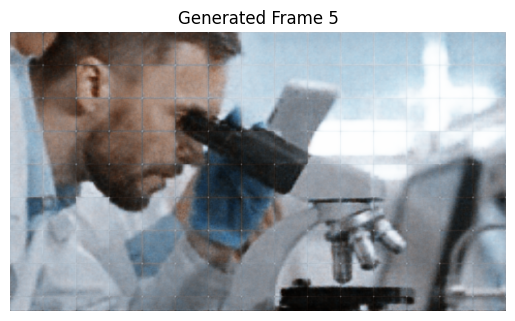

In [1]:
import os
import subprocess
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar during frame generation

# --- GPU Memory Management ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(f"Error setting GPU memory growth: {e}")

# --- 1. Convert Video to 1080p Using ffmpeg ---
video_input = "./input.mp4"
video_output = "input_1080p.mp4"

if not os.path.exists(video_input):
    raise FileNotFoundError(f"Input video '{video_input}' not found.")

if not os.path.exists(video_output):
    print("Converting video to 1080p...")
    cmd = [
        "ffmpeg",
        "-i", video_input,
        "-vf", "scale=1920:1080",
        "-y",  # Overwrite output if it exists
        video_output
    ]
    try:
        subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print("Video conversion completed.")
    except subprocess.CalledProcessError as e:
        raise RuntimeError(f"FFmpeg conversion failed: {e.stderr.decode()}")
else:
    print("1080p video already exists, skipping conversion.")

# --- 2. Extract Frames Using OpenCV ---
cap = cv2.VideoCapture(video_output)
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame_rgb)
cap.release()

if not frames:
    raise ValueError("No frames extracted from the video.")

frames = np.array(frames)
print(f"Extracted {frames.shape[0]} frames of size {frames.shape[2]}x{frames.shape[1]}.")

# Limit to 50 frames (changed from 10)
if frames.shape[0] > 50:
    frames = frames[:50]
    print("Using only the first 50 frames.")

num_frames, H, W, C = frames.shape
original_H, original_W = H, W  # Store original dimensions
print(f"Final dataset: {num_frames} frames of size {W}x{H}.")

# Normalize pixel values to [0, 1]
frames = frames.astype(np.float32) / 255.0

# --- 3. Define Block Size and Padding ---
block_size = 128

# Pad frames to make dimensions divisible by block_size
pad_H = (block_size - H % block_size) % block_size
pad_W = (block_size - W % block_size) % block_size

if pad_H > 0 or pad_W > 0:
    print(f"Padding frames to make dimensions divisible by {block_size}x{block_size}.")
    frames = np.pad(frames, ((0, 0), (0, pad_H), (0, pad_W), (0, 0)), mode='constant')
    H, W = frames.shape[1], frames.shape[2]
    print(f"New frame dimensions: {W}x{H}.")

# --- 4. Extract Non-Overlapping 128x128 Blocks from All Frames ---
def extract_blocks(frame, block_size):
    """Extract non-overlapping blocks from a frame."""
    H, W, _ = frame.shape
    blocks = []
    positions = []
    for i in range(0, H, block_size):
        for j in range(0, W, block_size):
            block = frame[i:i+block_size, j:j+block_size]
            blocks.append(block)
            positions.append((i, j))
    return blocks, positions

all_blocks = []
all_positions = []
all_frame_indices = []

for frame_idx, frame in enumerate(frames):
    blocks, positions = extract_blocks(frame, block_size)
    all_blocks.extend(blocks)
    all_positions.extend(positions)
    all_frame_indices.extend([frame_idx] * len(blocks))

all_blocks = np.array(all_blocks)
all_frame_indices = np.array(all_frame_indices)
all_positions = np.array(all_positions)

print(f"Extracted {all_blocks.shape[0]} blocks of shape {all_blocks.shape[1:]} from {len(frames)} frames.")

# --- 5. Prepare Dataset: Encode Frame Index + Block Position ---
def normalize_position(pos, max_dim):
    return pos / max_dim

# Normalize positions and frame indices to [0, 1]
normalized_positions = np.array([
    [normalize_position(i, H), normalize_position(j, W), frame_idx / len(frames)]
    for (i, j), frame_idx in zip(all_positions, all_frame_indices)
])

# --- 6. Build the Model ---
input_layer = tf.keras.Input(shape=(3,))  # [x, y, frame_idx]

# Positional encoding
def positional_encoding(x, num_encoding_functions=6):
    encoding = [x]
    for i in range(num_encoding_functions):
        encoding.append(tf.sin((2.0 ** i) * np.pi * x))
        encoding.append(tf.cos((2.0 ** i) * np.pi * x))
    return tf.concat(encoding, axis=-1)

pe = positional_encoding(input_layer)

# Convolutional decoder with batch normalization
x = tf.keras.layers.Dense(256, activation='relu')(pe)
x = tf.keras.layers.Reshape((1, 1, 256))(x)
x = tf.keras.layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu')(x)  # 1x1 -> 2x2
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu')(x)   # 2x2 -> 4x4
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2DTranspose(32, 4, strides=2, padding='same', activation='relu')(x)   # 4x4 -> 8x8
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2DTranspose(16, 4, strides=2, padding='same', activation='relu')(x)   # 8x8 -> 16x16
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2DTranspose(8, 4, strides=2, padding='same', activation='relu')(x)    # 16x16 -> 32x32
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2DTranspose(4, 4, strides=2, padding='same', activation='relu')(x)    # 32x32 -> 64x64
x = tf.keras.layers.BatchNormalization()(x)
output_layer = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')(x)  # 64x64 -> 128x128

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mae')

model.summary()  # Optional: View model architecture

# --- 7. Train the Model ---
history = model.fit(
    normalized_positions,
    all_blocks,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# --- 8. Generate a Frame ---
def generate_frame(target_frame_idx):
    frame_blocks = []
    total_blocks = (H // block_size) * (W // block_size)
    with tqdm(total=total_blocks, desc=f"Generating Frame {target_frame_idx}") as pbar:
        for i in range(0, H, block_size):
            for j in range(0, W, block_size):
                norm_i = i / H
                norm_j = j / W
                norm_frame_idx = target_frame_idx / len(frames)
                input_data = np.array([[norm_i, norm_j, norm_frame_idx]])
                pred_block = model.predict(input_data, verbose=0)[0]
                frame_blocks.append((pred_block, (i, j)))
                pbar.update(1)
    
    # Reconstruct frame
    reconstructed = np.zeros((H, W, 3), dtype=np.float32)
    for block, (i, j) in frame_blocks:
        reconstructed[i:i+block_size, j:j+block_size] = block
    
    # Convert to uint8 and crop to original size
    reconstructed = (reconstructed * 255).astype(np.uint8)
    reconstructed = reconstructed[:original_H, :original_W]  # Crop padding
    return reconstructed

# Generate and display frame 5
generated_frame = generate_frame(5)
plt.imshow(generated_frame)
plt.title("Generated Frame 5")
plt.axis('off')
plt.show()

In [2]:
# --- 8. Save the Model ---
model_save_path = "./saved_model"
print(f"Saving model to {model_save_path}...")
model.save(model_save_path)
print("Model saved successfully.")

Saving model to ./saved_model...


INFO:tensorflow:Assets written to: ./saved_model\assets


INFO:tensorflow:Assets written to: ./saved_model\assets


Model saved successfully.


In [1]:
import ffmpeg

input_file = "./input.mp4"
output_file = "./output.yuv"

(
    ffmpeg
    .input(input_file)
    .output(output_file, format='rawvideo', pix_fmt='yuv420p')
    .run(overwrite_output=True)
)

print("Conversion complete: input.mp4 → output.yuv")


Conversion complete: input.mp4 → output.yuv
